## Testing of maintenance rates

From experimental data we have produced a set of maintenance rate estimates for each oxygen concentration and each possible path through the ETS of Av (see ETS_Maintenance_Energy.ipynb). While assuming the lowest maintenance rate would be biologically relevant we will test each maintenance rate with an experimentally derived substrate uptake rate and determine how accurate it can predict growth. Data is from Khula and Oelze 1988 and was extracted using [WebplotDigitizer](https://automeris.io/WebPlotDigitizer).

In [2]:
import cobra.test
import pandas as pd
import matplotlib.pyplot as plt
from numpy.polynomial.polynomial import polyfit
import numpy as np
import seaborn as sns
import os
import math
from os.path import join
from cobra import Model, Reaction, Metabolite
from cobra.io import save_json_model


In [3]:
#Load data from Fig 4 of Khula and Oelze 

Fig4_data = pd.read_csv("../Data/Experimental_Data/Khula_Oelze_1988_Figure_4.csv")
print(len(Fig4_data))
Fig4_data.head()

36


,Oxygen_conc,Growth_rate,Sucrose_uptake_p,Sucrose_uptake_gcdw
0,192,0.05,11.63,8.81
1,192,0.07,13.06,9.89
2,192,0.10,14.85,11.25
3,192,0.16,16.07,12.18
4,192,0.17,16.48,12.48


In [4]:
#load ATPM predictions
ATPM_pred = pd.read_csv("../Data/Maintenance_rates/Maintenance_rates_pred.csv", index_col=0)
ATPM_pred.rename({'O2_concentration': 'Oxygen_conc', 'ATPM_bound_value': 'ATPM_pred'}, axis=1, inplace=True) 
print(len(ATPM_pred))
ATPM_pred.head()



40


,ETS_path,Oxygen_conc,group,ATPM_pred
0,NII_BD_F,12.0,NII_BD_F_12.0,16.258129
1,NII_BD_F,48.0,NII_BD_F_48.0,78.789395
2,NII_BD_F,108.0,NII_BD_F_108.0,110.805403
3,NII_BD_F,144.0,NII_BD_F_144.0,125.062531
4,NII_BD_F,192.0,NII_BD_F_192.0,143.071536


In [5]:
#Merge ATPM predictions and experimental data 

ATPM_pred_merge = pd.merge(left=ATPM_pred, right=Fig4_data, left_on='Oxygen_conc', right_on='Oxygen_conc')
ATPM_pred_merge.to_csv("../Data/Maintenance_rates/ATPM_pred_merge.csv")
ATPM_pred_merge.head()

,ETS_path,Oxygen_conc,group,ATPM_pred,Growth_rate,Sucrose_uptake_p,Sucrose_uptake_gcdw
0,NII_BD_F,12.0,NII_BD_F_12.0,16.258129,0.06,2.65,2.01
1,NII_BD_F,12.0,NII_BD_F_12.0,16.258129,0.07,2.96,2.24
2,NII_BD_F,12.0,NII_BD_F_12.0,16.258129,0.10,2.96,2.24
3,NII_BD_F,12.0,NII_BD_F_12.0,16.258129,0.12,3.16,2.40
4,NII_BD_F,12.0,NII_BD_F_12.0,16.258129,0.18,5.00,3.79


In [6]:
#reaction ids not in pathway then "name" of pathway
NII_BD_F = ["NADH6", "CYOO2pp", "RNF", "NII_BD_F"]
NII_CO_F = ["NADH6", "CYTBDpp", "RNF", "NII_CO_F"]
NII_BD_R = ["NADH6", "CYOO2pp", "FIX", "NII_BD_R"]
NII_CO_R = ["NADH6", "CYTBDpp", "FIX", "NII_CO_R"]
NI_BD_F = ["NADH5", "CYOO2pp", "RNF", "NI_BD_F"]
NI_CO_F = ["NADH5", "CYTBDpp", "RNF", "NI_CO_F"] 
NI_BD_R = ["NADH5", "CYOO2pp", "FIX", "NI_BD_R"]
NI_CO_R= ["NADH5", "CYTBDpp", "FIX", "NI_CO_R"]

all_paths = [NII_BD_F,
                NII_CO_F, 
                NII_BD_R,
                NII_CO_R,
                NI_BD_F,
                NI_CO_F,
                NI_BD_R,
                NI_CO_R]

In [7]:
#code adapated from midnighter on github https://github.com/opencobra/cobrapy/issues/771
def metabolite_flux_balance(metabolite, solution):
    """
    Return a vector of reaction fluxes scaled by the stoichiometric coefficient.

    Parameters
    ----------
    metabolite : cobra.Metabolite
        The metabolite whose fluxes are to be investigated.
    solution : cobra.Solution
        Solution with flux values.

    Returns
    -------
    pandas.Series
        A vector with fluxes of reactions that consume or produce the given
        metabolite scaled by the corresponding stoichiometric coefficients. The
        reaction identifiers are given by the index.
    """
    rxn_ids = list()
    rxn_sub = list()
    adj_flux = list()
    for rxn in metabolite.reactions:
        coef = rxn.get_coefficient(metabolite)
        rxn_ids.append(rxn.id)
        rxn_sub.append(rxn.subsystem)
        adj_flux.append(coef * solution.fluxes[rxn.id])
    return pd.DataFrame({'Rxn_id': rxn_ids, 'Subsystem': rxn_sub, 'Adjusted_Flux': adj_flux})



#functions that will pull the total ATP produced and the ratio of ATPM/Total ATP from the above function
def ATP_total(df):
    positive_num = df[(df.Adjusted_Flux > 0)]
    ATP_total = positive_num['Adjusted_Flux'].sum()
    
    return ATP_total

def ATP_ratio(df, ATP_total):
    ATPM = df.loc[df['Rxn_id'] == 'ATPM', 'Adjusted_Flux'].values[0]
    ATPM_ratio = (ATPM * -1)/ATP_total
    
    return ATPM_ratio

def growth_yeild(u_exp, u_pred, uptake_exp):
    growth_yeild_exp = u_exp / (uptake_exp / 1000)
    growth_yeild_pred = u_pred / (uptake_exp / 1000)
    
    return growth_yeild_exp, growth_yeild_pred


    
    


In [8]:
ATPM_pred_final = ATPM_pred_merge.sort_values(by=['ETS_path', 'Oxygen_conc'],ignore_index=True)
ATPM_pred_final.head(50)

,ETS_path,Oxygen_conc,group,ATPM_pred,Growth_rate,Sucrose_uptake_p,Sucrose_uptake_gcdw
0,NII_BD_F,12.0,NII_BD_F_12.0,16.258129,0.06,2.65,2.01
1,NII_BD_F,12.0,NII_BD_F_12.0,16.258129,0.07,2.96,2.24
2,NII_BD_F,12.0,NII_BD_F_12.0,16.258129,0.10,2.96,2.24
3,NII_BD_F,12.0,NII_BD_F_12.0,16.258129,0.12,3.16,2.40
4,NII_BD_F,12.0,NII_BD_F_12.0,16.258129,0.18,5.00,3.79
5,NII_BD_F,12.0,NII_BD_F_12.0,16.258129,0.26,6.48,4.91
6,NII_BD_F,12.0,NII_BD_F_12.0,16.258129,0.27,7.24,5.49
7,NII_BD_F,12.0,NII_BD_F_12.0,16.258129,0.28,6.73,5.10
8,NII_BD_F,48.0,NII_BD_F_48.0,78.789395,0.05,7.35,5.57
9,NII_BD_F,48.0,NII_BD_F_48.0,78.789395,0.06,6.38,4.83


The goal of the following functions is to take each row in the above table at test the model given an sucrose uptake rate and predicted ATPM rate. Each ATPM rate was previously determined for each branch in the ETS and the specific O2 concentration. I am sure there is a better way of doing this but there are some modeling overwriting intricacies we need to load a new model every time. So we will be making a new df taking data from the intial. First we declare all our variable list and ETS paths. Now we want to run our FBA simulation and determine the theoretical growth rate, as well as some other growth parameters. Within these for loops we want to make sure that the ETS paths match as they are repetitive. Then make sure we have no glucose uptake and the conditions are diazotrophic. Then remove all ETS enzymes not in the desired path. Give the model a specific sucrose uptake rate and ATPM rate. Next calculate the growth rate and other growth parameters and write each list to a df to save. 

In [9]:

ATPM_pred_final = ATPM_pred_merge.sort_values(by=['ETS_path', 'Oxygen_conc'],ignore_index=True)

def growth_rate_prediction(path_to_model, all_paths):
    suc_uptake = ATPM_pred_final['Sucrose_uptake_gcdw'].tolist()
    suc_uptake_it = []
    ATPM_flux = ATPM_pred_final['ATPM_pred'].tolist()
    ATPM_flux_it = []
    ETS_path = ATPM_pred_final['ETS_path'].tolist()
    ETS_path_it = []
    growth_rate_exp = ATPM_pred_final['Growth_rate'].tolist()
    growth_rate_exp_it = []
    o2_conc = ATPM_pred_final['Oxygen_conc'].tolist()
    o2_conc_it = []
    
    Growth_rate_pred = []
    Oxygen_consumption_pred = []
    ATP_production = []
    ATPM_ATP_prect = []
    growth_yeild_suc_pred = []
    growth_yeild_suc_exp = []
    growth_yeild_o2_pred = []
    growth_yeild_o2_exp = []
    
    for single_path in all_paths:
        
        for (i, j, k, l, m) in zip(ETS_path, suc_uptake, ATPM_flux, growth_rate_exp, o2_conc ):
        
            if i == single_path[3]:
            
                model = cobra.io.load_json_model(path_to_model)

                # Make sure glucose is set to zero
                model.reactions.get_by_id("EX_glc__D_e").lower_bound = 0
                model.reactions.get_by_id("EX_glc__D_e").upper_bound = 0

                # Make sure model is diazotrophic
                model.reactions.get_by_id("EX_nh4_e").lower_bound = 0
                model.reactions.get_by_id("EX_nh4_e").upper_bound = 0

                # set the flux to zero of corresponding reactions in pathway of interest
                model.reactions.get_by_id(single_path[0]).upper_bound = 0
                model.reactions.get_by_id(single_path[0]).lower_bound = 0

                model.reactions.get_by_id(single_path[1]).upper_bound = 0
                model.reactions.get_by_id(single_path[1]).lower_bound = 0

                model.reactions.get_by_id(single_path[2]).upper_bound = 0
                model.reactions.get_by_id(single_path[2]).lower_bound = 0

                # Set sucrose uptake to maintenance coefficient
                model.reactions.get_by_id("EX_sucr_e").lower_bound = -j
                model.reactions.get_by_id("EX_sucr_e").upper_bound = -j

                # Set ATPM to theoretical derived
                model.reactions.get_by_id("ATPM").upper_bound = 1000
                model.reactions.get_by_id("ATPM").lower_bound = k

                # solve the model

                solution = model.optimize()

                Growth_rate_pred.append(solution.objective_value)
                
                # append variables (copying output to df gave mixed reults so this is the way that works for me)
                growth_rate_exp_it.append(l)
                suc_uptake_it.append(j)
                ATPM_flux_it.append(k)
                ETS_path_it.append(i)
                o2_conc_it.append(m)
                
                # append outputs
                Oxygen_consumption_pred.append(solution.fluxes["O2tpp"])
                atp_total_df = metabolite_flux_balance(model.metabolites.atp_c, solution)
                atp_total_prod = ATP_total(atp_total_df)
                ATP_production.append(atp_total_prod)
                ATPM_ATP_prect.append(ATP_ratio(atp_total_df, atp_total_prod))
                growth_yeild_suc_pred.append(growth_yeild(l, solution.objective_value, j)[1])
                growth_yeild_suc_exp.append(growth_yeild(l, solution.objective_value, j)[0])
                growth_yeild_o2_pred.append(growth_yeild(l, solution.objective_value, solution.fluxes["O2tpp"])[1])
                growth_yeild_o2_exp.append(growth_yeild(l, solution.objective_value, solution.fluxes["O2tpp"])[0])
                #print("growth rate {} for path {} at {} sucrose uptake and {} ATPM ...".format(solution.objective_value, single_path[3], j, k, ))
            
            else:
            
                pass
            
        print("Calculated growth rates for path {} ".format(single_path[3]))  
        
    # create dict of all variables and iterations and turn into df   
    dict = {'Sucrose_uptake_gcdw':suc_uptake_it, 'O2_conc': o2_conc_it, 
            'ATPM_pred': ATPM_flux_it,
            'ETS_path': ETS_path_it,
            'Growth_rate_exp': growth_rate_exp_it,
            'Growth_rate_pred': Growth_rate_pred, 'Oxygen_consumption_pred': Oxygen_consumption_pred, 
            'ATP_production': ATP_production, 'ATPM_ATP_prect': ATPM_ATP_prect,
            'growth_yeild_suc_pred': growth_yeild_suc_pred, 'growth_yeild_suc_exp': growth_yeild_suc_exp,
            'growth_yeild_o2_pred': growth_yeild_o2_pred, 'growth_yeild_o2_exp': growth_yeild_o2_exp } 
    
    ATPM_pred_final_test = pd.DataFrame(dict)
    
    ATPM_pred_final_test.to_csv("../Outputs/Maintenance_rates/ATPM_pred_final_df.csv")
    
    

   


Lets run a single example outside the function as reference. 

In [10]:
model = cobra.io.load_json_model('../Data/Models/iAA1300.json')

# Make sure glucose is set to zero
model.reactions.get_by_id("EX_glc__D_e").lower_bound = 0
model.reactions.get_by_id("EX_glc__D_e").upper_bound = 0

# Make sure model is diazotrophic
model.reactions.get_by_id("EX_nh4_e").lower_bound = 0
model.reactions.get_by_id("EX_nh4_e").upper_bound = 0

# set the flux to zero of corresponding reactions in pathway of interest
model.reactions.get_by_id("NADH5").upper_bound = 0
model.reactions.get_by_id("NADH5").lower_bound = 0

model.reactions.get_by_id("CYTBDpp").upper_bound = 0
model.reactions.get_by_id("CYTBDpp").lower_bound = 0

model.reactions.get_by_id("RNF").upper_bound = 0
model.reactions.get_by_id("RNF").lower_bound = 0

# Set sucrose uptake to maintenance coefficient
model.reactions.get_by_id("EX_sucr_e").lower_bound = -13.95
model.reactions.get_by_id("EX_sucr_e").upper_bound = -13.95

# Set ATPM to theoretical derived
model.reactions.get_by_id("ATPM").upper_bound = 1000
model.reactions.get_by_id("ATPM").lower_bound = 446.72
                                 
solution = model.optimize()

print(solution.objective_value)
atp_total_df = metabolite_flux_balance(model.metabolites.atp_c, solution)
atp_total_prod = ATP_total(atp_total_df)
print(atp_total_prod)
print(ATP_ratio(atp_total_df, atp_total_prod))

0.8723462112884255
646.5042925298619
0.6909776240648334


In [11]:
 growth_rate_prediction("../Data/Models/iAA1300.json", all_paths)

#its running all of the single_paths for each o2 before going to the next -maybe sort the merge file before running script 

Calculated growth rates for path NII_BD_F 


KeyboardInterrupt: 

The function runs and take ~10 minutes, again I am sure there is a faster/cleaner way of doing this. 

In [3]:
#relod the dataframe
growth_compare = pd.read_csv("../Data/Maintenance_rates/ATPM_pred_final_df.csv", index_col = 0)
growth_compare.head()


,Sucrose_uptake_gcdw,O2_conc,ATPM_pred,ETS_path,Growth_rate_exp,Growth_rate_pred,Oxygen_consumption_pred,ATP_production,ATPM_ATP_prect,growth_yeild_suc_pred,growth_yeild_suc_exp,growth_yeild_o2_pred,growth_yeild_o2_exp
0,2.01,12,16.258129,NII_BD_F,0.06,0.094395,19.432741,39.352471,0.413141,46.962927,29.850746,4.857549,3.087573
1,2.24,12,16.258129,NII_BD_F,0.07,0.112532,21.292168,43.321077,0.375294,50.237446,31.250000,5.285130,3.287594
2,2.24,12,16.258129,NII_BD_F,0.10,0.112532,21.292168,43.321077,0.375294,50.237446,44.642857,5.285130,4.696563
3,2.40,12,16.258129,NII_BD_F,0.12,0.125149,22.585683,45.671348,0.355981,52.145209,50.000000,5.541055,5.313100
4,3.79,12,16.258129,NII_BD_F,0.18,0.234755,33.823092,69.296014,0.234619,61.940741,47.493404,6.940684,5.321808


In [4]:
# split ETS_path into ETC and F or R
ETS_path_new = growth_compare['ETS_path'].str.rsplit("_", n =1, expand = True)
growth_compare['ETS_path_1'] = ETS_path_new[0]
growth_compare['ETS_path_2'] = ETS_path_new[1]
growth_compare.head()


,Sucrose_uptake_gcdw,O2_conc,ATPM_pred,ETS_path,Growth_rate_exp,Growth_rate_pred,Oxygen_consumption_pred,ATP_production,ATPM_ATP_prect,growth_yeild_suc_pred,growth_yeild_suc_exp,growth_yeild_o2_pred,growth_yeild_o2_exp,ETS_path_1,ETS_path_2
0,2.01,12,16.258129,NII_BD_F,0.06,0.094395,19.432741,39.352471,0.413141,46.962927,29.850746,4.857549,3.087573,NII_BD,F
1,2.24,12,16.258129,NII_BD_F,0.07,0.112532,21.292168,43.321077,0.375294,50.237446,31.250000,5.285130,3.287594,NII_BD,F
2,2.24,12,16.258129,NII_BD_F,0.10,0.112532,21.292168,43.321077,0.375294,50.237446,44.642857,5.285130,4.696563,NII_BD,F
3,2.40,12,16.258129,NII_BD_F,0.12,0.125149,22.585683,45.671348,0.355981,52.145209,50.000000,5.541055,5.313100,NII_BD,F
4,3.79,12,16.258129,NII_BD_F,0.18,0.234755,33.823092,69.296014,0.234619,61.940741,47.493404,6.940684,5.321808,NII_BD,F


Now that we have our data prepped and into two different groups differentiating ferredoxin reduction and oxygen reduction we can compare growth rates and get r2 values. First lets look at results in two different ways first group by oxygen concentration and Fix vs Rnf.

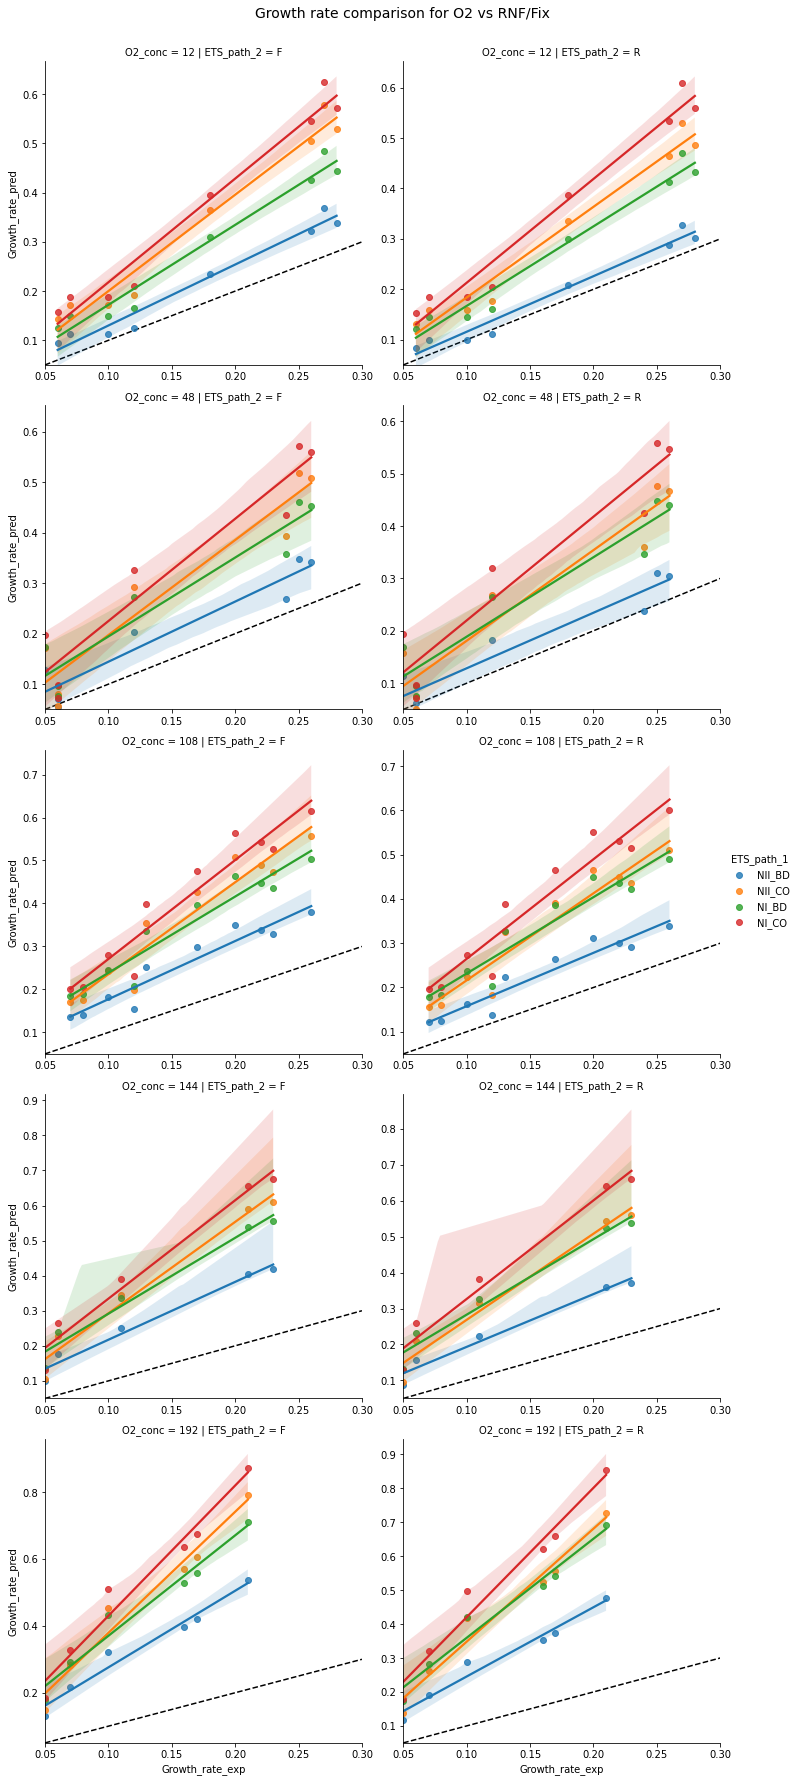

In [15]:
g =sns.lmplot(data = growth_compare, x = 'Growth_rate_exp', y ='Growth_rate_pred', row = "O2_conc", col = 'ETS_path_2', hue = 'ETS_path_1',
              sharey = False, sharex = False)
for ax in g.axes.flat:
    ax.axline((0, 0), slope=1, ls="--", c = 'k', zorder=0)
g.set(ylim=(0.05, None), xlim =(0.05, 0.3))
g.fig.subplots_adjust(top=0.95)
g.fig.suptitle('Growth rate comparison for O2 vs RNF/Fix', size = 14)
g.savefig('../Outputs/ATPM_compare/GR_compare_O2_FR.tiff', dpi = 60)

As we cab see the respiratory protection branch NII_BD (blue) is the most accurate in lower O2 concentrations but most models are not accurate in higher concentrations. To see the ETS accuracy better lets divide the graph to look at ETS vs Rnf/Fix

Text(0.5, 0.98, 'Growth rate comparison for ETS vs RNF/Fix')

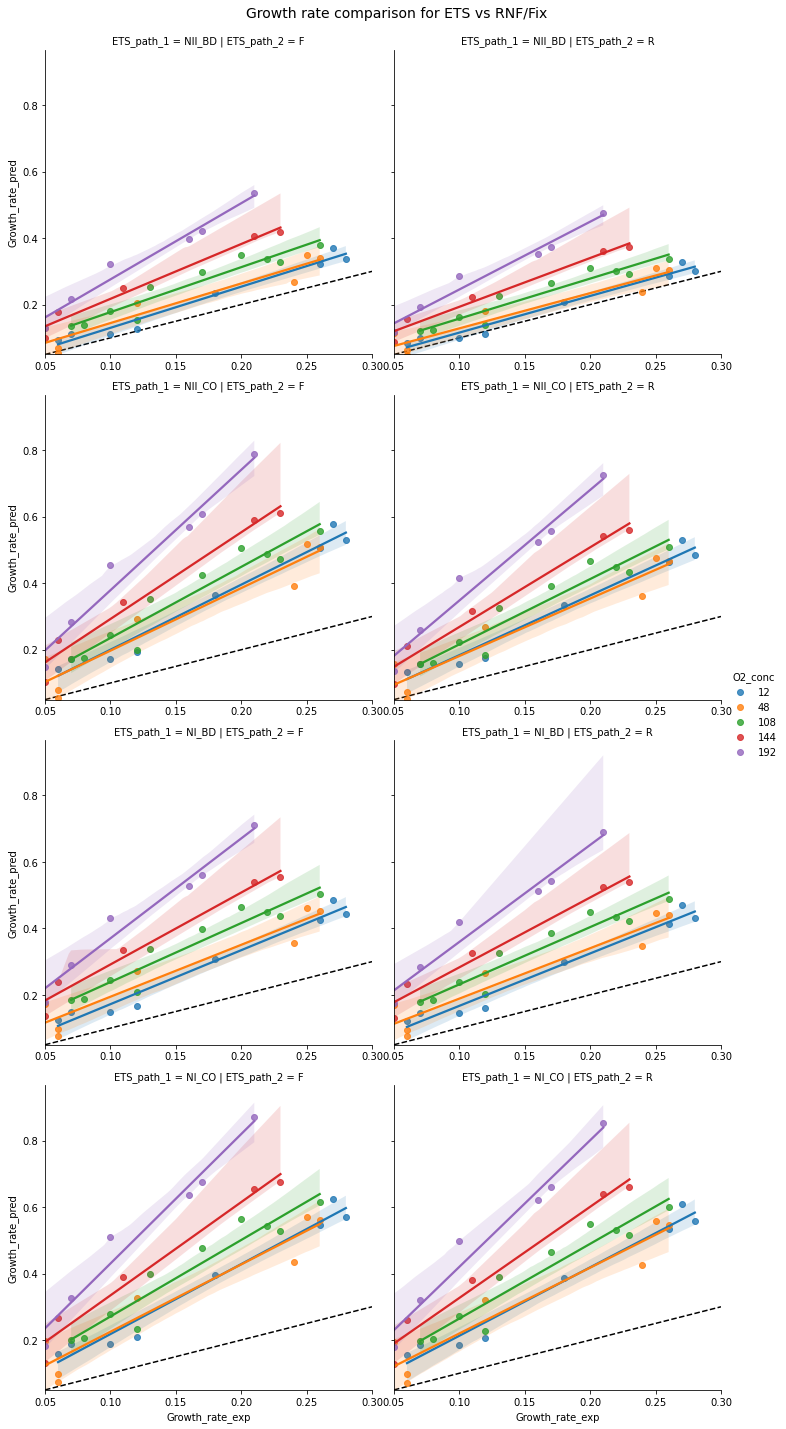

In [16]:
g =sns.lmplot(data = growth_compare, x = 'Growth_rate_exp', y ='Growth_rate_pred', row = 'ETS_path_1', col = 'ETS_path_2', hue = "O2_conc",
              sharey = True, sharex = False)
for ax in g.axes.flat:
    ax.axline((0, 0), slope=1, ls="--", c = 'k', zorder=0)
g.set(ylim=(0.05, None), xlim =(0.05, 0.3))
g.fig.subplots_adjust(top=0.95)
g.fig.suptitle('Growth rate comparison for ETS vs RNF/Fix', size = 14)


As we can see NII_BD is the best model that fits the experimental data compared to the other ETS systems. We can see some differences in the Rnf vs Fix but lets put them next to each other to see how they stack in each scenario 

Text(0.5, 0.98, 'Growth rate comparison for ETS vs Rnf/Fix')

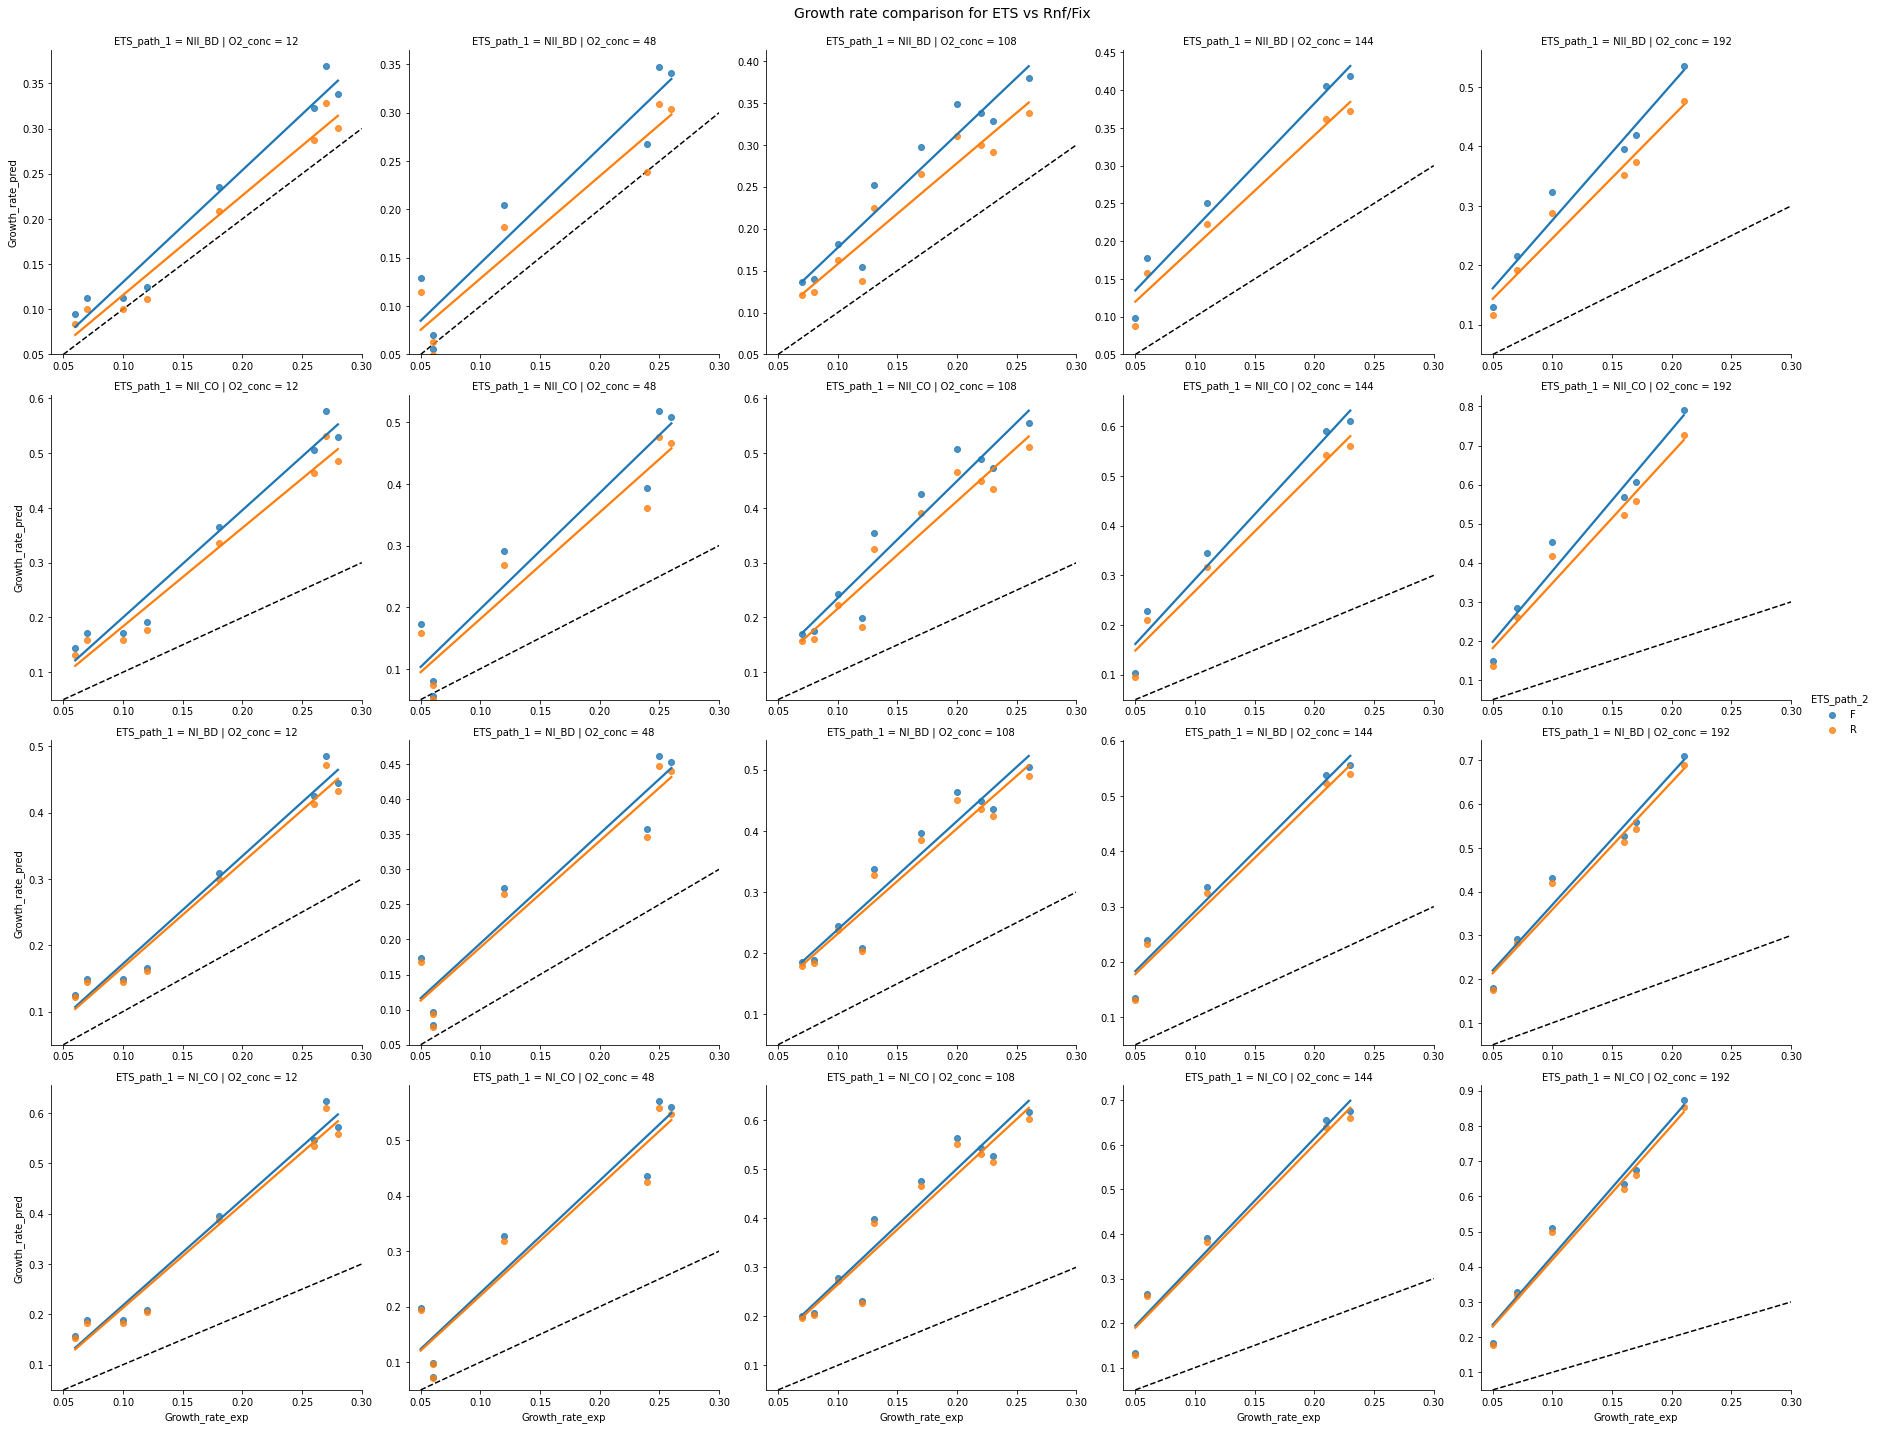

In [17]:
g =sns.lmplot(data = growth_compare, x = 'Growth_rate_exp', y ='Growth_rate_pred', row = 'ETS_path_1', col = 'O2_conc', hue = 'ETS_path_2',
              sharey = False, sharex = False, ci = None)
for ax in g.axes.flat:
    ax.axline((0, 0), slope=1, ls="--", c = 'k', zorder=0)
g.set(ylim=(0.05, None), xlim =(0.04, 0.3))
g.fig.subplots_adjust(top=0.95)
g.fig.suptitle('Growth rate comparison for ETS vs Rnf/Fix', size = 14)


Subset data into two set for figure:
   
   1) RNF_BD_NDHII
   2) RNF_CO_NDHI

Compare both with above plot examples.

Next we will try to replicate a plot of sucrose uptake vs growth rate for 
    

In [18]:
growth_compare_sub = growth_compare[(growth_compare["ETS_path"] == "NII_BD_R") | (growth_compare["ETS_path"] == "NI_CO_R")]
growth_compare_sub.head()

,Sucrose_uptake_gcdw,O2_conc,ATPM_pred,ETS_path,Growth_rate_exp,Growth_rate_pred,Oxygen_consumption_pred,ATP_production,ATPM_ATP_prect,growth_yeild_suc_pred,growth_yeild_suc_exp,growth_yeild_o2_pred,growth_yeild_o2_exp,ETS_path_1,ETS_path_2
72,2.01,12,16.258129,NII_BD_R,0.06,0.084005,19.948703,37.474070,0.433850,41.793364,29.850746,4.211034,3.007714,NII_BD,R
73,2.24,12,16.258129,NII_BD_R,0.07,0.100145,21.907263,41.081776,0.395750,44.707432,31.250000,4.571299,3.195287,NII_BD,R
74,2.24,12,16.258129,NII_BD_R,0.10,0.100145,21.907263,41.081776,0.395750,44.707432,44.642857,4.571299,4.564696,NII_BD,R
75,2.40,12,16.258129,NII_BD_R,0.12,0.111372,23.269740,43.226172,0.376118,46.405193,50.000000,4.786150,5.156912,NII_BD,R
76,3.79,12,16.258129,NII_BD_R,0.18,0.208914,35.106256,64.709316,0.251249,55.122457,47.493404,5.950908,5.127291,NII_BD,R


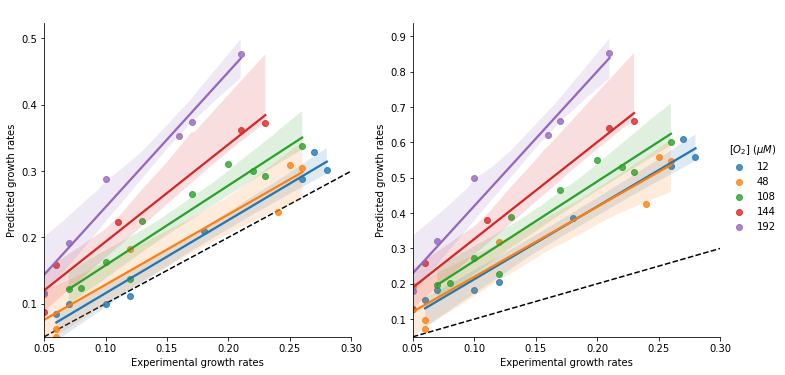

In [19]:
g =sns.lmplot(data = growth_compare_sub, x = 'Growth_rate_exp', y ='Growth_rate_pred', col = 'ETS_path', hue = "O2_conc",
              sharey = False, sharex = True, legend_out = True)
for ax in g.axes.flat:
    ax.axline((0, 0), slope=1, ls="--", c = 'k', zorder=0)
g.set(ylim=(0.05, None), xlim =(0.05, 0.3))
g.fig.subplots_adjust(top=0.95)
g._legend.set_title("$[O_2]$ ($\mu M$)")
#g.fig.get_axes()[1].legend(loc='upper right')

axes = g.axes.flatten()
axes[0].set_title(" ")
axes[1].set_title(" ")
axes[0].set_ylabel("Predicted growth rates")
axes[1].set_ylabel("Predicted growth rates")
for ax in axes:
    ax.set_xlabel("Experimental growth rates")
plt.subplots_adjust(wspace=0.2)
g.savefig('../Outputs/ATPM_compare/Figure_growth_compare_col_final.tiff', dpi = 60)

In [20]:
#subset to just wanted columns
growth_compare_sub = growth_compare[(growth_compare["ETS_path"] == "NII_BD_R")]
growth_compare_sub_sub = growth_compare_sub[['Growth_rate_exp', 'Growth_rate_pred', 'Sucrose_uptake_gcdw', 'ETS_path', 'O2_conc']]
growth_compare_sub_melt = growth_compare_sub_sub.melt(id_vars=['Sucrose_uptake_gcdw', 'ETS_path', 'O2_conc'], 
              value_vars=['Growth_rate_exp', 'Growth_rate_pred',],
              var_name='Source', value_name='Growth Rate')
growth_compare_sub_melt["Grouped"] = growth_compare_sub_melt["O2_conc"].astype(str) + growth_compare_sub_melt["Source"]
growth_compare_sub_melt.head()


,Sucrose_uptake_gcdw,ETS_path,O2_conc,Source,Growth Rate,Grouped
0,2.01,NII_BD_R,12,Growth_rate_exp,0.06,12Growth_rate_exp
1,2.24,NII_BD_R,12,Growth_rate_exp,0.07,12Growth_rate_exp
2,2.24,NII_BD_R,12,Growth_rate_exp,0.10,12Growth_rate_exp
3,2.40,NII_BD_R,12,Growth_rate_exp,0.12,12Growth_rate_exp
4,3.79,NII_BD_R,12,Growth_rate_exp,0.18,12Growth_rate_exp


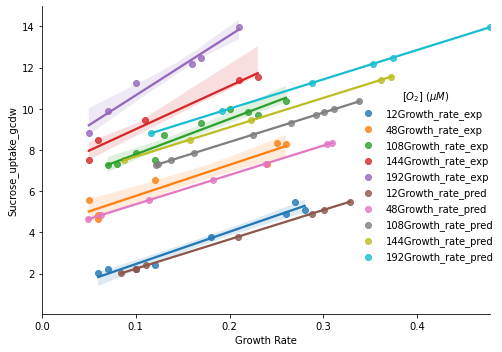

In [21]:
#plot sucrose uptake against growth rate for experimental and predicted

g =sns.lmplot(data = growth_compare_sub_melt, x = 'Growth Rate', y ='Sucrose_uptake_gcdw', hue = "Grouped",
              sharey = True, sharex = False, legend_out = True)
g.set(ylim=(0.05, None), xlim =(0, None))
g.fig.subplots_adjust(top=0.95)
g._legend.set_title("$[O_2]$ ($\mu M$)")
#g.fig.get_axes()[1].legend(loc='upper right')


plt.tight_layout()


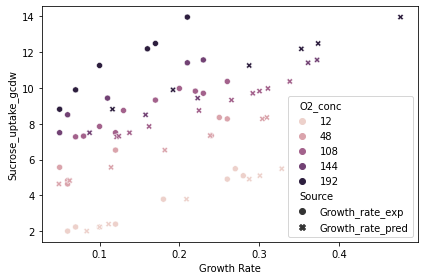

In [22]:
#plot sucrose uptake against growth rate for experimental and predicted

sns.scatterplot(data = growth_compare_sub_melt, x = 'Growth Rate', y ='Sucrose_uptake_gcdw', hue = "O2_conc", style = 'Source')
plt.tight_layout()


Text(0.5, 0.98, 'Sucrose Growth Yeild at different O2 concentrations')

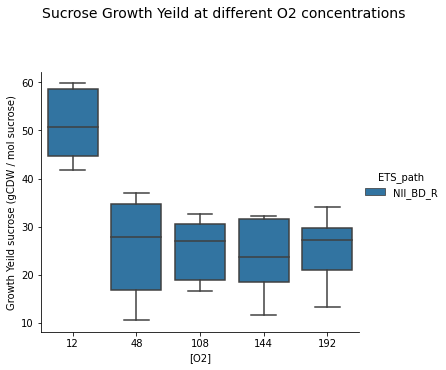

In [23]:
ax = sns.catplot( x = 'O2_conc', y = 'growth_yeild_suc_pred',  hue = 'ETS_path', data = growth_compare_sub, kind = 'box')
ax.set_axis_labels('[O2]','Growth Yeild sucrose (gCDW / mol sucrose)')
ax.fig.subplots_adjust(top=0.8)
ax.fig.suptitle('Sucrose Growth Yeild at different O2 concentrations', size = 14)
#add experimental?

C:\Users\alexa\anaconda3\envs\Metabolic_models\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


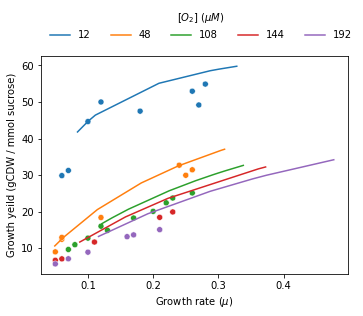

In [24]:
growth_compare_sub['O2_conc'] = growth_compare_sub['O2_conc'].astype(str)
fig, ax = plt.subplots(figsize = (5.5,4))
sns.lineplot( x = 'Growth_rate_pred', y = 'growth_yeild_suc_pred',  hue = 'O2_conc', data = growth_compare_sub, ax=ax)
sns.scatterplot( x = 'Growth_rate_exp', y = 'growth_yeild_suc_exp',  hue = 'O2_conc', data = growth_compare_sub, ax=ax, legend = False)
lgd = ax.legend(bbox_to_anchor=(0,1.25), loc=2,frameon=False, title = "$[O_2]$ ($\mu M$)", ncol=5)
ax.set(xlabel = 'Growth rate ($\mu$)', ylabel = 'Growth yeild (gCDW / mmol sucrose)')
fig.savefig('../Outputs/ATPM_compare/Growth_yield_mu.tiff', bbox_inches='tight', dpi = 60)


In [25]:
# melt data to build box plots for ATP production % atp to maintenance and oxygen consumption
growth_compare_sub_sub2 = growth_compare_sub[['Oxygen_consumption_pred', 'ATP_production', 'ATPM_ATP_prect', 'O2_conc']]
growth_compare_sub_melt2 = growth_compare_sub_sub2.melt(id_vars=['O2_conc'], 
              value_vars=['ATP_production','Oxygen_consumption_pred',  'ATPM_ATP_prect'],
              var_name='Reaction', value_name='Value')

growth_compare_sub_melt2.head()

,O2_conc,Reaction,Value
0,12,ATP_production,37.474070
1,12,ATP_production,41.081776
2,12,ATP_production,41.081776
3,12,ATP_production,43.226172
4,12,ATP_production,64.709316


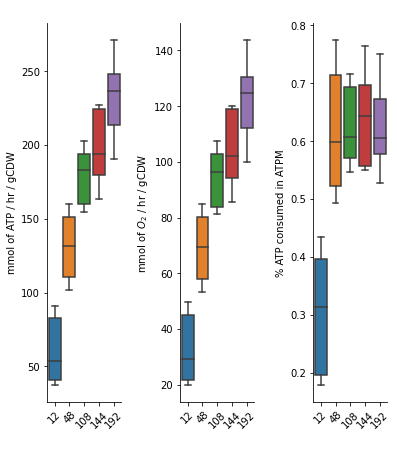

In [26]:
g = sns.catplot( x = 'O2_conc', y = 'Value', col = 'Reaction', hue = 'O2_conc', data = growth_compare_sub_melt2, kind = "box",
             col_wrap=3, orient="v", sharey = False,
             height = 6, aspect = 0.3, dodge = False)
g.set_xticklabels(rotation=45)
g.axes[0].set_ylabel('mmol of ATP / hr / gCDW')
g.axes[1].set_ylabel('mmol of $O_2$ / hr / gCDW')
g.axes[2].set_ylabel('% ATP consumed in ATPM')
g.axes[0].set_xlabel(' ')
g.axes[1].set_xlabel(' ')
g.axes[2].set_xlabel(' ')
g.axes[0].set_title(' ')
g.axes[1].set_title(' ')
g.axes[2].set_title(' ')
plt.subplots_adjust(wspace=0.8)
g.savefig('../Outputs/ATPM_compare/tripel_plot.tiff', dpi = 60)

<AxesSubplot:xlabel='O2_conc', ylabel='ATPM_ATP_prect'>

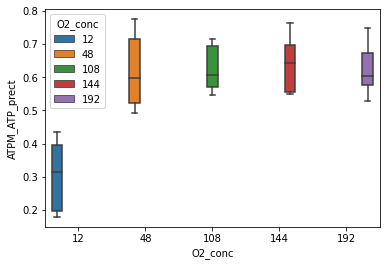

In [27]:
sns.boxplot( x = 'O2_conc', y = 'ATPM_ATP_prect',  hue = 'O2_conc', data = growth_compare_sub)

<AxesSubplot:xlabel='O2_conc', ylabel='Oxygen_consumption_pred'>

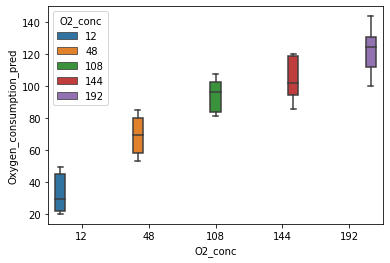

In [28]:
sns.boxplot( x = 'O2_conc', y = 'Oxygen_consumption_pred',  hue = 'O2_conc', data = growth_compare_sub)

Visually we can see that the RNF_NII_BD path is the most efficenet at reducing the ATPM rate and minimizing the amount of ATP needed to be produced. It is interesting that we are overestimating growth rate in every scenario. Biologically meaning that the predicted ATPM is not high enough! This is still very interesting in that we need to dissect the fluxes to where all this extra energy might be going.

But before we continue to make visual assumptions lets prove which models are more accurate. 

In [29]:
from sklearn import metrics 
def get_metrics(x):
    d = {}
    d['MSE'] = metrics.mean_squared_error(x["Growth_rate_exp"], x["Growth_rate_pred"])
    d['MAE'] = metrics.mean_absolute_error(x["Growth_rate_exp"], x["Growth_rate_pred"])
    d['RMSE'] = np.sqrt(metrics.mean_squared_error(x["Growth_rate_exp"], x["Growth_rate_pred"]))
    return pd.Series(d, index=['MSE', 'MAE', 'RMSE'])

metrics_df = growth_compare.groupby(['ETS_path', 'O2_conc']).apply(get_metrics)   

metrics_df.to_csv("../Outputs/ATPM_compare/reg_metrics_ETS_O2.csv")
metrics_df

MSE       MAE      RMSE
ETS_path O2_conc                              
NII_BD_F 12       0.002911  0.046162  0.053950
         48       0.004342  0.055034  0.065896
         108      0.010736  0.097781  0.103614
         144      0.021937  0.138065  0.148112
         192      0.050347  0.210283  0.224381
NII_BD_R 12       0.000872  0.024799  0.029527
         48       0.001937  0.034901  0.044014
         108      0.005545  0.069625  0.074466
         144      0.013367  0.108337  0.115614
         192      0.034056  0.173192  0.184544
NII_CO_F 12       0.034840  0.164622  0.186656
         48       0.028881  0.141090  0.169945
         108      0.047540  0.201450  0.218037
         144      0.075294  0.243937  0.274398
         192      0.145973  0.348919  0.382064
NII_CO_R 12       0.024414  0.137510  0.156250
         48       0.020359  0.118843  0.142683
         108      0.034820  0.172107  0.186601
         144      0.057474  0.213249  0.239738
         192      0.115323  0.310096  0.339592
NI_BD_F  12       0.016558  0.114176  0.128677
         48       0.019402  0.121724  0.139292
         108      0.037273  0.183518  0.193062
         144      0.060772  0.228684  0.246520
         192      0.119058  0.323612  0.345047
NI_BD_R  12       0.014289  0.105960  0.119537
         48       0.017028  0.113840  0.130491
         108      0.033334  0.173557  0.182576
         144      0.055219  0.218164  0.234986
         192      0.109535  0.310479  0.330961
NI_CO_F  12       0.047235  0.192531  0.217335
         48       0.042493  0.174712  0.206139
         108      0.069482  0.246270  0.263595
         144      0.105095  0.292091  0.324183
         192      0.195330  0.407266  0.441961
NI_CO_R  12       0.043312  0.184308  0.208115
         48       0.039057  0.167328  0.197628
         108      0.064386  0.237036  0.253744
         144      0.098187  0.282404  0.313347
         192      0.183791  0.395070  0.428708

With MAE and RMSE the lower the better so this shows what we visually saw that NII_BD_R predicts growth the best because it lowers the ATPM rate. While this makes sense we should also justify the RNF vs FIX diferrence. Logically when using NDHII Fix contributes proton motive force while Rnf consumes proton motive force, so if the goal is to minimize the ATP maintenance (which it is in our model) Rnf is going to be favored. But if we were to account for the large ATPM rate with other factors use of Fix would be favorable due to it more efficient bifurcation reaction. 

We can see this in the regression statistics of the fully coupled pathway as NI_CO_R is "more accurate" than NI_CO_F. While in this higher oxygen high carbon consumption example it is true but the most efficient path in an low oxygen low carbon scenario should be NI_CO_F as it maximize biomass yeild. 

Lets discet to relationship between RNF anf Fix below:

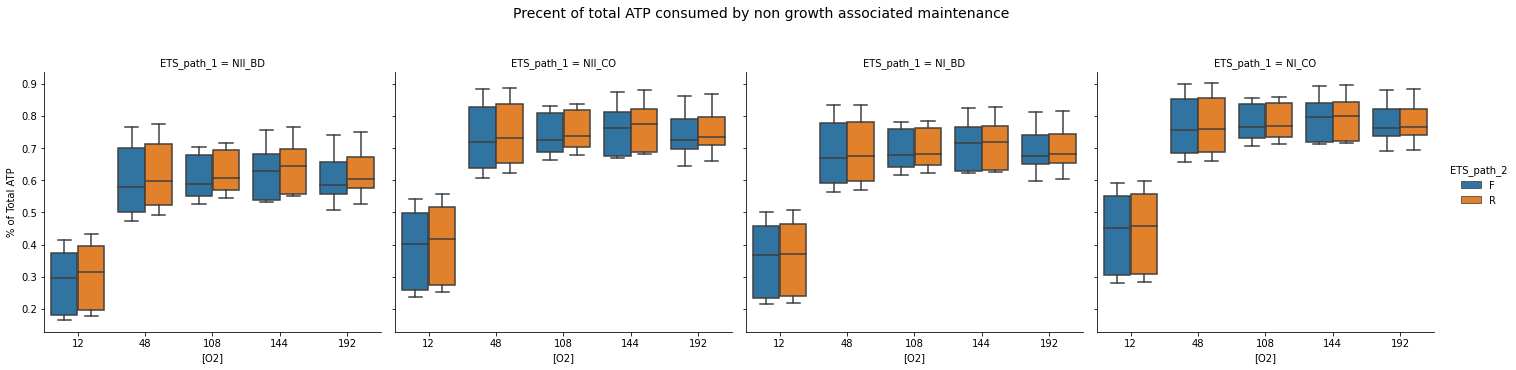

In [30]:
growth_compare['ATPM_ATP_prect'] = pd.to_numeric(growth_compare['ATPM_ATP_prect'])
ax = sns.catplot( x = 'O2_conc', y = 'ATPM_ATP_prect', col= 'ETS_path_1', hue = 'ETS_path_2', data = growth_compare, kind = 'box')
ax.set_axis_labels('[O2]','% of Total ATP')
ax.fig.subplots_adjust(top=0.8)
ax.fig.suptitle('Precent of total ATP consumed by non growth associated maintenance', size = 14)
ax.savefig('../Outputs/ATPM_compare/prect_ATP_ETS_FR.tiff', dpi = 60)

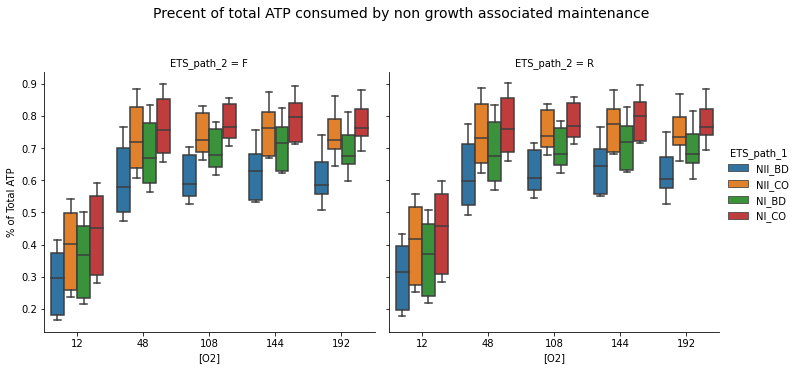

In [31]:
growth_compare['ATPM_ATP_prect'] = pd.to_numeric(growth_compare['ATPM_ATP_prect'])
ax = sns.catplot( x = 'O2_conc', y = 'ATPM_ATP_prect', col= 'ETS_path_2', hue = 'ETS_path_1', data = growth_compare, kind = 'box')
ax.set_axis_labels('[O2]','% of Total ATP')
ax.fig.subplots_adjust(top=0.8)
ax.fig.suptitle('Precent of total ATP consumed by non growth associated maintenance', size = 14)
ax.savefig('../Outputs/ATPM_compare/prect_ATP_FR_ETS.tiff', dpi = 60)

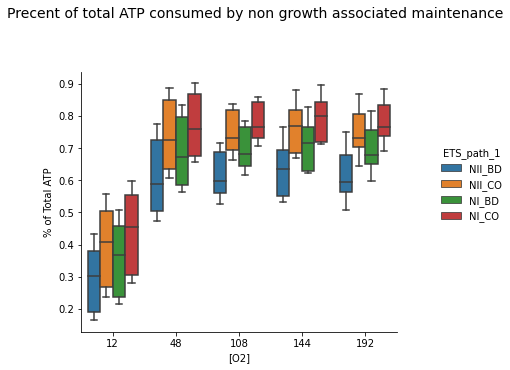

In [32]:
growth_compare['ATPM_ATP_prect'] = pd.to_numeric(growth_compare['ATPM_ATP_prect'])
ax = sns.catplot( x = 'O2_conc', y = 'ATPM_ATP_prect', hue = 'ETS_path_1', data = growth_compare, kind = 'box')
ax.set_axis_labels('[O2]','% of Total ATP')
ax.fig.subplots_adjust(top=0.8)
ax.fig.suptitle('Precent of total ATP consumed by non growth associated maintenance', size = 14)
ax.savefig('../Outputs/ATPM_compare/prect_ATP_ETS.tiff', dpi = 60)

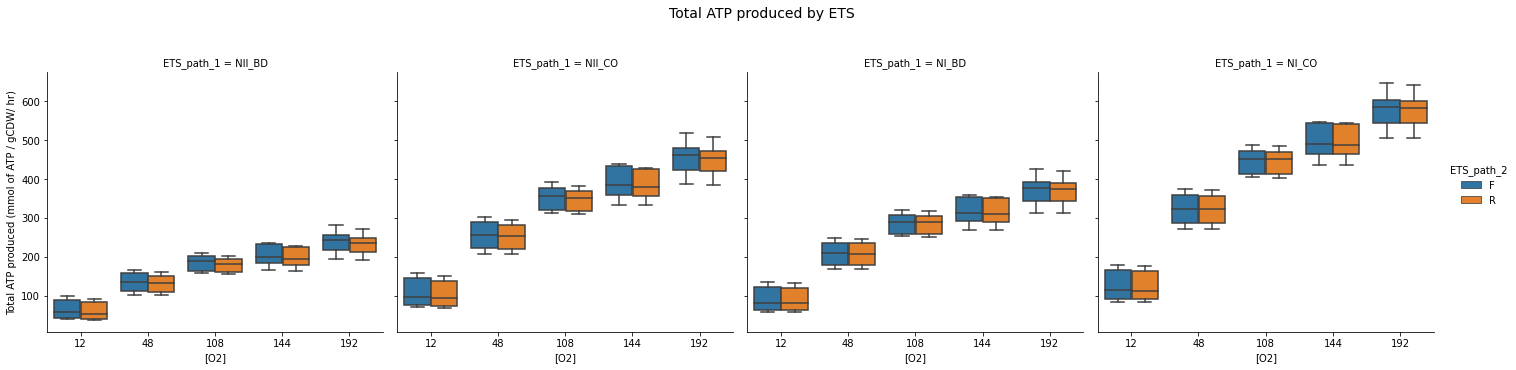

In [33]:

ax = sns.catplot( x = 'O2_conc', y = 'ATP_production', col= 'ETS_path_1', hue = 'ETS_path_2', data = growth_compare, kind = 'box')
ax.set_axis_labels('[O2]','Total ATP produced (mmol of ATP / gCDW/ hr)')
ax.fig.subplots_adjust(top=0.8)
ax.fig.suptitle('Total ATP produced by ETS', size = 14)
ax.savefig('../Outputs/ATPM_compare/total_ATP_ETS_FR.tiff', dpi = 60)

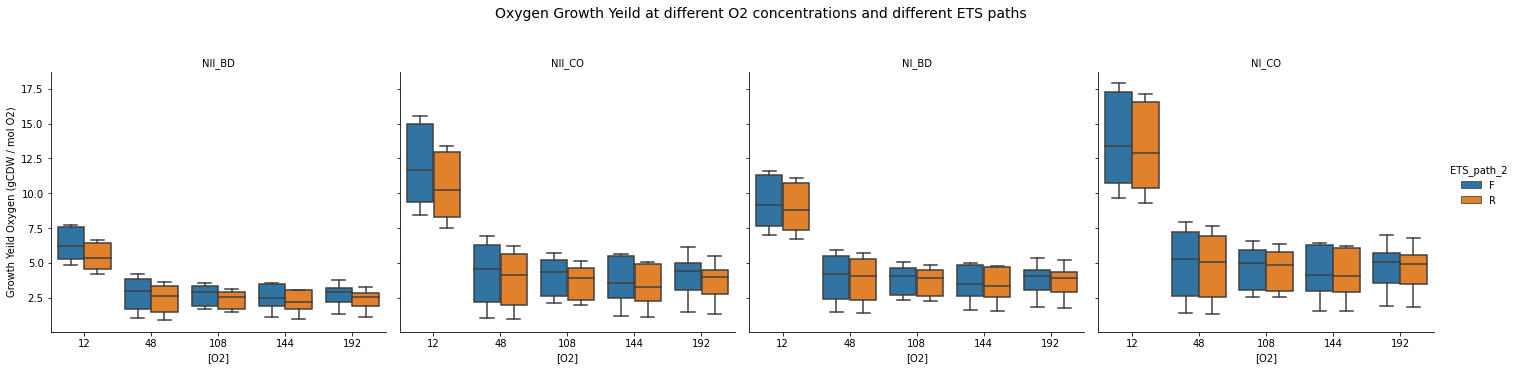

In [34]:

ax = sns.catplot( x = 'O2_conc', y = 'growth_yeild_o2_pred', col= 'ETS_path_1', hue = 'ETS_path_2', data = growth_compare, kind = 'box')
ax.set_axis_labels('[O2]','Growth Yeild Oxygen (gCDW / mol O2)')
ax.set_titles(col_template = "{col_name}")
ax.fig.subplots_adjust(top=0.8)
ax.fig.suptitle('Oxygen Growth Yeild at different O2 concentrations and different ETS paths', size = 14)
ax.savefig('../Outputs/ATPM_compare/growthyeild_o2_ETS_FR.tiff', dpi = 30)

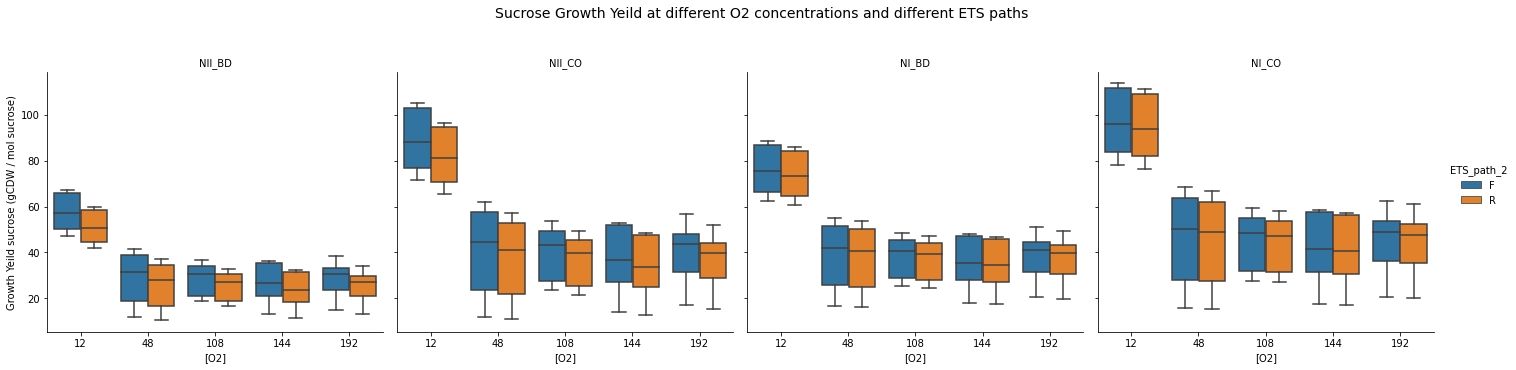

In [35]:
ax = sns.catplot( x = 'O2_conc', y = 'growth_yeild_suc_pred', col= 'ETS_path_1', hue = 'ETS_path_2', data = growth_compare, kind = 'box')
ax.set_axis_labels('[O2]','Growth Yeild sucrose (gCDW / mol sucrose)')
ax.set_titles(col_template = "{col_name}")
ax.fig.subplots_adjust(top=0.8)
ax.fig.suptitle('Sucrose Growth Yeild at different O2 concentrations and different ETS paths', size = 14)
ax.savefig('../Outputs/ATPM_compare/growthyeild_suc_ETS_FR.tiff', dpi = 60)
#add experimental?

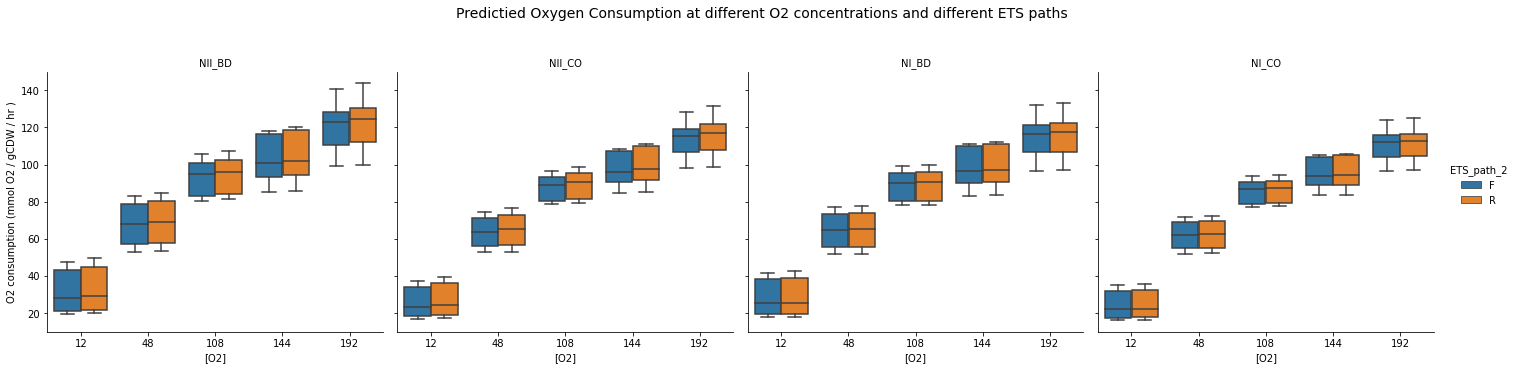

In [36]:
ax = sns.catplot( x = 'O2_conc', y = 'Oxygen_consumption_pred', col= 'ETS_path_1', hue = 'ETS_path_2', data = growth_compare, kind = 'box')
ax.set_axis_labels('[O2]','O2 consumption (mmol O2 / gCDW / hr )')
ax.set_titles(col_template = "{col_name}")
ax.fig.subplots_adjust(top=0.8)
ax.fig.suptitle('Predictied Oxygen Consumption at different O2 concentrations and different ETS paths', size = 14)
ax.savefig('../Outputs/ATPM_compare/o2_consump_ETS_FR.tiff', dpi = 60)

Text(0.5, 0.98, 'Predictied Oxygen Consumption at differentt ETS paths')

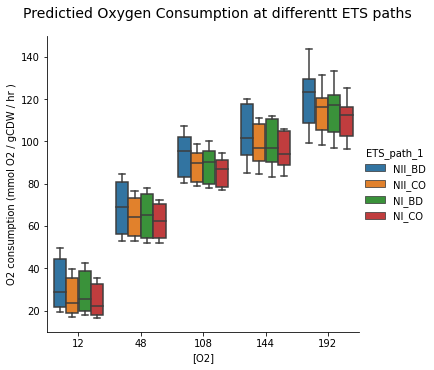

In [37]:
ax = sns.catplot( x = 'O2_conc', y = 'Oxygen_consumption_pred', hue = 'ETS_path_1', data = growth_compare, kind = 'box')
ax.set_axis_labels('[O2]','O2 consumption (mmol O2 / gCDW / hr )')
ax.fig.subplots_adjust(top=0.90)
ax.fig.suptitle('Predictied Oxygen Consumption at differentt ETS paths', size = 14)


There are some differences between RNF and FIx but they are very close. we will look at fluxes of rnf vs fix in the NII_BD model. 

In [29]:
#get model fluxes for 12 and 108 O2 concentrations for ~0.2 growth rate

f_12_test = ["NII_BD_F", "NADH6", "CYOO2pp", "RNF", "12", 3.79, 16.25 ]
r_12_test = ["NII_BD_R","NADH6", "CYOO2pp", "FIX", "12", 3.79, 16.25]
f_108_test = ["NII_BD_F", "NADH6", "CYOO2pp", "RNF", "108", 9.97, 110.8 ]
r_108_test = ["NII_BD_R","NADH6", "CYOO2pp", "FIX", "12", 9.97, 110.8]

test_all = [f_12_test, r_12_test, f_108_test, r_108_test]

fluxs_all = []
growth_rates = []

for i in test_all:
    

    model = cobra.io.load_json_model('../Data/Models/iAA1300.json')

    # Make sure glucose is set to zero
    model.reactions.get_by_id("EX_glc__D_e").lower_bound = 0
    model.reactions.get_by_id("EX_glc__D_e").upper_bound = 0

    # Make sure model is diazotrophic
    model.reactions.get_by_id("EX_nh4_e").lower_bound = 0
    model.reactions.get_by_id("EX_nh4_e").upper_bound = 0

    # set the flux to zero of corresponding reactions in pathway of interest
    model.reactions.get_by_id(i[1]).upper_bound = 0
    model.reactions.get_by_id(i[1]).lower_bound = 0

    model.reactions.get_by_id(i[2]).upper_bound = 0
    model.reactions.get_by_id(i[2]).lower_bound = 0

    model.reactions.get_by_id(i[3]).upper_bound = 0
    model.reactions.get_by_id(i[3]).lower_bound = 0

    # Set sucrose uptake to maintenance coefficient
    model.reactions.get_by_id("EX_sucr_e").lower_bound = -i[5]
    model.reactions.get_by_id("EX_sucr_e").upper_bound = -i[5]

    # Set ATPM to theoretical derived
    model.reactions.get_by_id("ATPM").upper_bound = 1000
    model.reactions.get_by_id("ATPM").lower_bound = i[6]
                                 
    solution = model.optimize()
    growth_rates.append(solution.objective_value)
    fluxs_all.append(pd.DataFrame.from_dict([solution.fluxes]).T)
    


In [30]:
growth_rates

[0.23478746016734015,
 0.20894263526369342,
 0.3493227367057295,
 0.31087015087090475]

In [41]:
#get model fluxes for 12 and 108 O2 concentrations for ~0.2 growth rate

f_12_test = ["NII_BD_F", "NADH6", "CYOO2pp", "RNF", "12", "EX_nh4_e", 3.79, 16.25 ]
r_12_test = ["NII_BD_R","NADH6", "CYOO2pp", "FIX", "12", "EX_nh4_e", 3.79, 16.25]
f_108_test = ["NII_BD_F", "NADH6", "CYOO2pp", "RNF", "108", "EX_nh4_e", 9.97, 110.8 ]
r_108_test = ["NII_BD_R","NADH6", "CYOO2pp", "FIX", "12", "EX_nh4_e", 9.97, 110.8]


test_all = [f_12_test, r_12_test, f_108_test, r_108_test]

fluxs_all = []
growth_rates_nh4 = []

for i in test_all:
    

    model = cobra.io.load_json_model('../Data/Models/iAA1300_C.json')

    # Make sure glucose is set to zero
    model.reactions.get_by_id("EX_glc__D_e").lower_bound = 0
    model.reactions.get_by_id("EX_glc__D_e").upper_bound = 0


    # set the flux to zero of corresponding reactions in pathway of interest
    model.reactions.get_by_id(i[1]).upper_bound = 0
    model.reactions.get_by_id(i[1]).lower_bound = 0

    model.reactions.get_by_id(i[2]).upper_bound = 0
    model.reactions.get_by_id(i[2]).lower_bound = 0

    model.reactions.get_by_id(i[3]).upper_bound = 0
    model.reactions.get_by_id(i[3]).lower_bound = 0

    model.reactions.get_by_id(i[5]).upper_bound = 1000
    model.reactions.get_by_id(i[5]).lower_bound = 0
    # Set sucrose uptake to maintenance coefficient
    model.reactions.get_by_id("EX_sucr_e").lower_bound = -i[6]
    model.reactions.get_by_id("EX_sucr_e").upper_bound = -i[6]

    # Set ATPM to theoretical derived
    model.reactions.get_by_id("ATPM").upper_bound = 1000
    model.reactions.get_by_id("ATPM").lower_bound = i[7]
                                 
    solution = model.optimize()
    growth_rates_nh4.append(solution.objective_value)
    fluxs_all.append(pd.DataFrame.from_dict([solution.fluxes]).T)
    


In [42]:
growth_rates_nh4

[0.20362944363446545,
 0.1811391991761032,
 0.26634609622129035,
 0.23692899077912566]

In [46]:
model = cobra.io.load_json_model('../Data/Models/iAA1300_C.json')

# Make sure glucose is set to zero
model.reactions.get_by_id("EX_glc__D_e").lower_bound = 0
model.reactions.get_by_id("EX_glc__D_e").upper_bound = 0


# set the flux to zero of corresponding reactions in pathway of interest
model.reactions.get_by_id("NADH6").upper_bound = 0
model.reactions.get_by_id("NADH6").lower_bound = 0

model.reactions.get_by_id("CYTBDpp").upper_bound = 0
model.reactions.get_by_id("CYTBDpp").lower_bound = 0


# Set sucrose uptake to maintenance coefficient
model.reactions.get_by_id("EX_sucr_e").lower_bound = -10
model.reactions.get_by_id("EX_sucr_e").upper_bound = -10

# Set ATPM to theoretical derived
model.reactions.get_by_id("ATPM").upper_bound = 1000
model.reactions.get_by_id("ATPM").lower_bound = 110


solution = model.optimize()
print(solution.objective_value)

0.8768266760813307
